In [1]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = f'/gxfs_work1/geomar/smomw523/master-thesis/output_data/retention/backwards/'

In [3]:
import warnings
warnings.filterwarnings('ignore')

all_files = glob.glob(os.path.join(path, "2*.csv"))
dates = pd.date_range(start='2009-01-01', end='2009-12-31', freq = '5D')
df = pd.concat((pd.read_csv(f, index_col=0,skipfooter=1) for f in all_files), keys=dates)
df.index.names = ['start_date', 'obs']

In [4]:
dx = df.to_xarray()

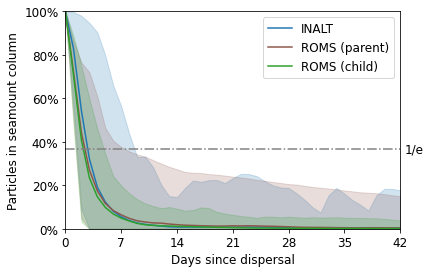

In [5]:
mean_values = dx['INALT-ML'].mean(dim='start_date')
upper_envelope = dx['INALT-ML'].max(dim='start_date')
lower_envelope = dx['INALT-ML'].min(dim='start_date')

mean_values_ROMS = dx['ROMS-ML'].mean(dim='start_date')
upper_envelope_ROMS = dx['ROMS-ML'].max(dim='start_date')
lower_envelope_ROMS = dx['ROMS-ML'].min(dim='start_date')

mean_values_ROMSchild = dx['ROMSchild-ML'].mean(dim='start_date')
upper_envelope_ROMSchild = dx['ROMSchild-ML'].max(dim='start_date')
lower_envelope_ROMSchild = dx['ROMSchild-ML'].min(dim='start_date')

# Plot
plt.plot(np.arange(len(dx.obs)), mean_values, color='tab:blue',label='INALT')
plt.fill_between(np.arange(len(dx.obs)), lower_envelope,
                 upper_envelope, color='tab:blue', alpha=0.2)

plt.plot(np.arange(len(dx.obs)), mean_values_ROMS, color='tab:brown',label='ROMS (parent)')
plt.fill_between(np.arange(len(dx.obs)), lower_envelope_ROMS,
                 upper_envelope_ROMS, color='tab:brown', alpha=0.2)

plt.plot(np.arange(len(dx.obs)), mean_values_ROMSchild, color='tab:green',label='ROMS (child)')
plt.fill_between(np.arange(len(dx.obs)), lower_envelope_ROMSchild,
                 upper_envelope_ROMSchild, color='tab:green', alpha=0.2)

plt.axhline(y=1/np.e, color='gray', linestyle='-.')
plt.text(42.5,0.35,'1/e',fontsize=12)
plt.xticks([0,7,14,21,28,35,42],fontsize=12)
plt.yticks([0,0.2,.4,.6,.8,1],['0%','20%','40%','60%','80%','100%'],fontsize=12)
plt.xlim([0,42])
plt.ylim([0,1])
plt.ylabel('Particles in seamount column',fontsize=12)
plt.xlabel('Days since dispersal',fontsize=12)
#plt.title('Surface to MLD')
plt.legend(fontsize=12)
plt.show();

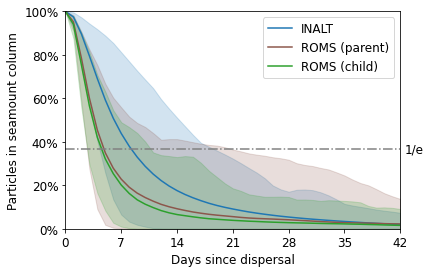

In [6]:
mean_values = dx['INALT-ML-to-tip'].mean(dim='start_date')
upper_envelope = dx['INALT-ML-to-tip'].max(dim='start_date')
lower_envelope = dx['INALT-ML-to-tip'].min(dim='start_date')

mean_values_ROMS = dx['ROMS-ML-to-tip'].mean(dim='start_date')
upper_envelope_ROMS = dx['ROMS-ML-to-tip'].max(dim='start_date')
lower_envelope_ROMS = dx['ROMS-ML-to-tip'].min(dim='start_date')

mean_values_ROMSchild = dx['ROMSchild-ML-to-tip'].mean(dim='start_date')
upper_envelope_ROMSchild = dx['ROMSchild-ML-to-tip'].max(dim='start_date')
lower_envelope_ROMSchild = dx['ROMSchild-ML-to-tip'].min(dim='start_date')
# Plot
plt.plot(np.arange(len(dx.obs)), mean_values, color='tab:blue',label='INALT')
plt.fill_between(np.arange(len(dx.obs)), lower_envelope,
                 upper_envelope, color='tab:blue', alpha=0.2)

plt.plot(np.arange(len(dx.obs)), mean_values_ROMS, color='tab:brown',label='ROMS (parent)')
plt.fill_between(np.arange(len(dx.obs)), lower_envelope_ROMS,
                 upper_envelope_ROMS, color='tab:brown', alpha=0.2)

plt.plot(np.arange(len(dx.obs)), mean_values_ROMSchild, color='tab:green',label='ROMS (child)')
plt.fill_between(np.arange(len(dx.obs)), lower_envelope_ROMSchild,
                 upper_envelope_ROMSchild, color='tab:green', alpha=0.2)

plt.axhline(y=1/np.e, color='gray', linestyle='-.')
plt.text(42.5,0.35,'1/e',fontsize=12)
plt.xticks([0,7,14,21,28,35,42],fontsize=12)
plt.yticks([0,0.2,.4,.6,.8,1],['0%','20%','40%','60%','80%','100%'],fontsize=12)
plt.xlim([0,42])
plt.ylim([0,1])
plt.ylabel('Particles in seamount column',fontsize=12)
plt.xlabel('Days since dispersal',fontsize=12)
#plt.title('MLD to tip')
plt.legend(fontsize=12)
plt.show();

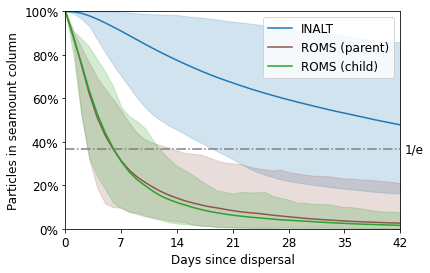

In [7]:
mean_values = dx['INALT-tip-to-1500'].mean(dim='start_date')
upper_envelope = dx['INALT-tip-to-1500'].max(dim='start_date')
lower_envelope = dx['INALT-tip-to-1500'].min(dim='start_date')

mean_values_ROMS = dx['ROMS-tip-to-1500'].mean(dim='start_date')
upper_envelope_ROMS = dx['ROMS-tip-to-1500'].max(dim='start_date')
lower_envelope_ROMS = dx['ROMS-tip-to-1500'].min(dim='start_date')

mean_values_ROMSchild = dx['ROMSchild-tip-to-1500'].mean(dim='start_date')
upper_envelope_ROMSchild = dx['ROMSchild-tip-to-1500'].max(dim='start_date')
lower_envelope_ROMSchild = dx['ROMSchild-tip-to-1500'].min(dim='start_date')

# Plot
plt.plot(np.arange(len(dx.obs)), mean_values, color='tab:blue',label='INALT')
plt.fill_between(np.arange(len(dx.obs)), lower_envelope,
                 upper_envelope, color='tab:blue', alpha=0.2)

plt.plot(np.arange(len(dx.obs)), mean_values_ROMS, color='tab:brown',label='ROMS (parent)')
plt.fill_between(np.arange(len(dx.obs)), lower_envelope_ROMS,
                 upper_envelope_ROMS, color='tab:brown', alpha=0.2)

plt.plot(np.arange(len(dx.obs)), mean_values_ROMSchild, color='tab:green',label='ROMS (child)')
plt.fill_between(np.arange(len(dx.obs)), lower_envelope_ROMSchild,
                 upper_envelope_ROMSchild, color='tab:green', alpha=0.2)

plt.axhline(y=1/np.e, color='gray', linestyle='-.')
plt.text(42.5,0.35,'1/e',fontsize=12)
plt.xticks([0,7,14,21,28,35,42],fontsize=12)
plt.yticks([0,0.2,.4,.6,.8,1],['0%','20%','40%','60%','80%','100%'],fontsize=12)
plt.xlim([0,42])
plt.ylim([0,1])
plt.ylabel('Particles in seamount column',fontsize=12)
plt.xlabel('Days since dispersal',fontsize=12)
#plt.title('ML to tip')
plt.legend(fontsize=12)
plt.show();

In [8]:
# First time passing threshold
ML_INALT, ML_ROMS, ML_ROMSchild = [], [], []
MLtip_INALT, MLtip_ROMS, MLtip_ROMSchild = [], [], []
tip1500_INALT, tip1500_ROMS, tip1500_ROMSchild = [], [], []
threshold = 1/np.e

for j in np.arange(len(dx.start_date)):
    dx.isel(start_date=j)['INALT-ML'].plot()
    dx.isel(start_date=j)['ROMS-ML'].plot()
    dx.isel(start_date=j)['ROMSchild-ML'].plot()
    dx.isel(start_date=j)['INALT-ML-to-tip'].plot()
    dx.isel(start_date=j)['ROMS-ML-to-tip'].plot()
    dx.isel(start_date=j)['ROMSchild-ML-to-tip'].plot()
    dx.isel(start_date=j)['INALT-tip-to-1500'].plot()
    dx.isel(start_date=j)['ROMS-tip-to-1500'].plot()
    dx.isel(start_date=j)['ROMSchild-tip-to-1500'].plot()

    lines = plt.gca().get_lines()
    x_data = lines[0].get_xdata()
    y_data1 = lines[0].get_ydata()
    y_data2 = lines[1].get_ydata()
    y_data3 = lines[2].get_ydata()
    y_data4 = lines[3].get_ydata()
    y_data5 = lines[4].get_ydata()
    y_data6 = lines[5].get_ydata()
    y_data7 = lines[6].get_ydata()
    y_data8 = lines[7].get_ydata()
    y_data9 = lines[8].get_ydata()

    intersec_INALT, intersec_INALT2, intersec_INALT3 = None, None, None
    intersec_ROMS, intersec_ROMS2, intersec_ROMS3 = None, None, None
    intersec_ROMSchild, intersec_ROMSchild2, intersec_ROMSchild3 = None, None, None

    for i in range(len(x_data)):
        if y_data1[i] < threshold and intersec_INALT is None:
            intersec_INALT = x_data[i]
        if y_data2[i] < threshold and intersec_ROMS is None:
            intersec_ROMS = x_data[i]
        if y_data3[i] < threshold and intersec_ROMSchild is None:
            intersec_ROMSchild = x_data[i]
        if y_data4[i] < threshold and intersec_INALT2 is None:
            intersec_INALT2 = x_data[i]
        if y_data5[i] < threshold and intersec_ROMS2 is None:
            intersec_ROMS2 = x_data[i]
        if y_data6[i] < threshold and intersec_ROMSchild2 is None:
            intersec_ROMSchild2 = x_data[i]
        if y_data7[i] < threshold and intersec_INALT3 is None:
            intersec_INALT3 = x_data[i]
        if y_data8[i] < threshold and intersec_ROMS3 is None:
            intersec_ROMS3 = x_data[i]
        if y_data9[i] < threshold and intersec_ROMSchild3 is None:
            intersec_ROMSchild3 = x_data[i]
    
    ML_INALT.append(intersec_INALT)
    ML_ROMS.append(intersec_ROMS)
    ML_ROMSchild.append(intersec_ROMSchild)
    MLtip_INALT.append(intersec_INALT2)
    MLtip_ROMS.append(intersec_ROMS2)
    MLtip_ROMSchild.append(intersec_ROMSchild2)
    tip1500_INALT.append(intersec_INALT3)
    tip1500_ROMS.append(intersec_ROMS3)
    tip1500_ROMSchild.append(intersec_ROMSchild3)
    plt.close()

In [9]:
dict = {'INALT-ML': ML_INALT,'INALT-ML-to-tip': MLtip_INALT,'INALT-tip-to-1500': tip1500_INALT,
        'ROMS-ML': ML_ROMS,'ROMS-ML-to-tip': MLtip_ROMS,'ROMS-tip-to-1500': tip1500_ROMS,
        'ROMSchild-ML': ML_ROMSchild,'ROMSchild-ML-to-tip': MLtip_ROMSchild,'ROMSchild-tip-to-1500': tip1500_ROMSchild}

In [10]:
retentions = pd.DataFrame(dict,index=dates).fillna(43.5)

In [11]:
retentions

,INALT-ML,INALT-ML-to-tip,INALT-tip-to-1500,ROMS-ML,ROMS-ML-to-tip,ROMS-tip-to-1500,ROMSchild-ML,ROMSchild-ML-to-tip,ROMSchild-tip-to-1500
2009-01-01,9,5,43.5,4,4,3,3,4,6
2009-01-06,6,11,43.5,3,4,8,2,4,8
2009-01-11,3,13,43.5,4,4,6,3,4,5
2009-01-16,3,13,43.5,2,5,6,2,5,7
2009-01-21,3,10,43.5,2,5,10,3,5,9
...,...,...,...,...,...,...,...,...,...
2009-12-07,5,5,19.0,2,4,6,3,5,6
2009-12-12,3,5,21.0,3,4,6,4,5,5
2009-12-17,3,17,43.5,2,5,7,2,5,8
2009-12-22,2,8,41.0,3,4,6,3,5,6


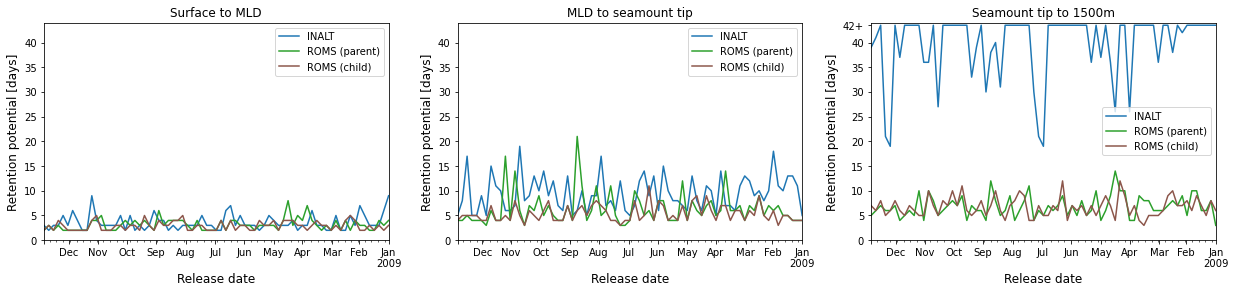

In [13]:
plt.figure(figsize=(21,4))
plt.subplot(1, 3,1)
retentions['INALT-ML'].plot(color='tab:blue',label='INALT')
retentions['ROMS-ML'].plot(color='tab:green',label='ROMS (parent)')
retentions['ROMSchild-ML'].plot(color='tab:brown',label='ROMS (child)')
plt.title('Surface to MLD', fontsize=12)
plt.xlabel('Release date', fontsize =12)
plt.ylabel('Retention potential [days]', fontsize =12)
plt.ylim([0,44])
plt.gca().invert_xaxis()
plt.legend()

plt.subplot(1, 3,2)
retentions['INALT-ML-to-tip'].plot(color='tab:blue',label='INALT')
retentions['ROMS-ML-to-tip'].plot(color='tab:green',label='ROMS (parent)')
retentions['ROMSchild-ML-to-tip'].plot(color='tab:brown',label='ROMS (child)')
plt.title('MLD to seamount tip', fontsize=12)
plt.xlabel('Release date', fontsize =12)
plt.ylabel('Retention potential [days]', fontsize =12)
plt.ylim([0,44])
plt.gca().invert_xaxis()
plt.legend()

plt.subplot(1, 3,3)
retentions['INALT-tip-to-1500'].plot(color='tab:blue',label='INALT')
#plt.scatter(dates,retentions['INALT-tip-to-1500'],color='tab:blue',s=4)
retentions['ROMS-tip-to-1500'].plot(color='tab:green',label='ROMS (parent)')
retentions['ROMSchild-tip-to-1500'].plot(color='tab:brown',label='ROMS (child)')
plt.title('Seamount tip to 1500m', fontsize=12)
plt.xlabel('Release date', fontsize =12)
plt.ylabel('Retention potential [days]', fontsize =12)
plt.ylim([0,44])
plt.yticks([0,5,10,15,20,25,30,35,40,43.5],[0,5,10,15,20,25,30,35,40,'42+'])
plt.gca().invert_xaxis()
plt.legend();

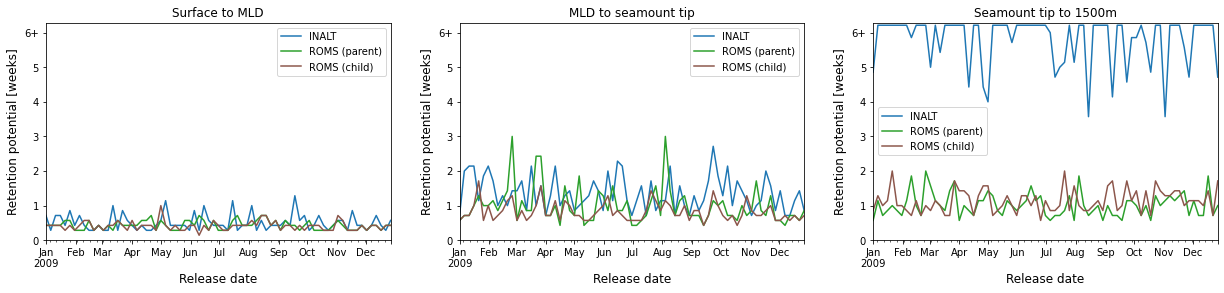

In [13]:
plt.figure(figsize=(21,4))
plt.subplot(1, 3,1)
retentions['INALT-ML'].plot(color='tab:blue',label='INALT')
retentions['ROMS-ML'].plot(color='tab:green',label='ROMS (parent)')
retentions['ROMSchild-ML'].plot(color='tab:brown',label='ROMS (child)')
plt.title('Surface to MLD', fontsize=12)
plt.xlabel('Release date', fontsize =12)
plt.ylabel('Retention potential [weeks]', fontsize =12)
plt.ylim([0,44])
plt.yticks([0,7,14,21,28,35,42],[0,1,2,3,4,5,'6+'])
plt.legend()

plt.subplot(1, 3,2)
retentions['INALT-ML-to-tip'].plot(color='tab:blue',label='INALT')
retentions['ROMS-ML-to-tip'].plot(color='tab:green',label='ROMS (parent)')
retentions['ROMSchild-ML-to-tip'].plot(color='tab:brown',label='ROMS (child)')
plt.title('MLD to seamount tip', fontsize=12)
plt.xlabel('Release date', fontsize =12)
plt.ylabel('Retention potential [weeks]', fontsize =12)
plt.ylim([0,44])
plt.yticks([0,7,14,21,28,35,42],[0,1,2,3,4,5,'6+'])
plt.legend()

plt.subplot(1, 3,3)
retentions['INALT-tip-to-1500'].plot(color='tab:blue',label='INALT')
#plt.scatter(dates,retentions['INALT-tip-to-1500'],color='tab:blue',s=4)
retentions['ROMS-tip-to-1500'].plot(color='tab:green',label='ROMS (parent)')
retentions['ROMSchild-tip-to-1500'].plot(color='tab:brown',label='ROMS (child)')
plt.title('Seamount tip to 1500m', fontsize=12)
plt.xlabel('Release date', fontsize =12)
plt.ylabel('Retention potential [weeks]', fontsize =12)
plt.ylim([0,44])
plt.yticks([0,7,14,21,28,35,42],[0,1,2,3,4,5,'6+'])
plt.legend();